# Exploratory Data Analysis

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

Import Python modules

In [2]:
import os
from datetime import datetime
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator

In [3]:
sns.set_context("talk")

Import any custom modules

In [4]:
%aimport src.utils
from src.utils import (
    show_df,  # Display first and last n rows of a DataFrame
    show_df_dtypes_nans,  # Show the missing values and column datatypes side-by-side
)

<a href="table-of-contents"></a>

## [Table of Contents](#table-of-contents)
0. [About](#about)
1. [User Inputs](#user-inputs)
2. [Load processed and combined dataset of search results and listings](#load-processed-and-combined-dataset-of-search-results-and-listings)
   - 2.1. [Load data](#load-data)
3. [Cleaning](#cleaning)
   - 3.1. [Publisher](#publisher)
   - 3.2. [Rating](#rating)
   - 3.3. [Prices](#prices)
   - 3.4. [Date Columns](#date-columns)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
   - 4.1. [Early Access](#early-access)
   - 4.2. [Platforms](#platforms)
   - 4.3. [Franchises](#franchises)
   - 4.4. [Publishers and Platforms](#publishers-and-platforms)
   - 4.5. [Publishers and Early Access listings](#publishers-and-early-access-listings)
   - 4.6. [Publishers and Multi-Language Support](#publishers-and-multi-language-support)
   - 4.7. [Developers](#developers)
   - 4.8. [Digital Rights Management](#digital-rights-management)
   - 4.9. [Genres and User-Defined Tags](#genres-and-user-defined-tags)
   - 4.10. [Ratings](#ratings)
   - 4.11. [Publishers](#publishers)
   - 4.12. [User Rating](#user-rating)
   - 4.13. [Listing Prices](#listing-prices)
   - 4.14. [Listing Prices over time](#listing-prices-over-time)

<a id="about"></a>

## 0. [About](#about)

In this notebook, we'll explore the processed dataset created by merging the scraped search results with the scraped listings. Recall that only the dataset acquired using the `requests` library is being considered for analysis. See section 4, of `6_merge_searches_listings.ipynb` for details about this.

<a id="user-inputs"></a>

## 1. [User Inputs](#user-inputs)

Define variables that can be changed when running this notebook

In [5]:
PROJ_ROOT_DIR = os.getcwd()

In [6]:
proc_data_filename = "processed_data.csv"

In [7]:
# Path to data
data_dir = os.path.join(PROJ_ROOT_DIR, "data")

# Path to data/processed
processed_data_dir = os.path.join(data_dir, "processed")

# Path to processed data file
processed_data_filepath = os.path.join(processed_data_dir, proc_data_filename)

# Path to reports directory for saving plots
reports_data_dir = os.path.join(PROJ_ROOT_DIR, "reports", "figures")

# Define list of months for heatmap
months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

<a id="load-processed-and-combined-dataset-of-search-results-and-listings"></a>

## 2. [Load processed and combined dataset of search results and listings](#load-processed-and-combined-dataset-of-search-results-and-listings)

<a id="load-data"></a>

### 2.1. [Load data](#load-data)

We'll begin by loading the processed data that was exported in `6_merge_searches_listings.ipynb` to a CSV file. Recall that this is a combination of the scraped search results and listings datasets so there are more columns here than in either of those two datasets

In [8]:
%%time
df = pd.read_csv(processed_data_filepath)
print(len(df))
show_df(df, 1)
show_df_dtypes_nans(df)

10035


,review_type_all,overall_review_rating,pct_overall,pct_overall_threshold,pct_overall_lang,pct_overall_threshold_lang,platforms,user_defined_tags,num_steam_achievements,drm,rating,rating_descriptors,review_type_positive,review_type_negative,review_language_mine,Title,Genre,Release Date,Early Access Release Date,Developer,Publisher,Franchise,languages,num_languages,page_num,listing_num,url,filename,app_id,is_collection,discount_pct,original_price,discount_price
0,nan,Very Positive,90.000000,positive,nan,nan,win,"Early Access, Co-op, Naval Combat, Online Co-Op, Character Customization, FPS, Pirates, Historical, Open World, PvP, Fast-Paced, Battle Royale, First-Person, Survival, Team-Based, Competitive, Funny, Shooter, Action, Naval",nan,"Requires agreement to a 3rd-party EULA, Blazing Sails EULA",nan,nan,nan,nan,nan,Blazing Sails,"Action, Adventure, Casual, Indie, Early Access","Nov 5, 2020","Sep 9, 2020",Get Up Games,Iceberg Interactive,Iceberg Interactive,True,15.000000,50,1,https://store.steampowered.com/app/1158940/Blazing_Sails/,p50_l1_Blazing_Sails.csv,1158940,False,-30%,14.99,10.490000
10034,nan,Mostly Positive,73.000000,positive,nan,nan,"win, mac","Survival, Simulation, Strategy, Indie, RPG, Adventure, Management, Crafting, Singleplayer, Casual, Resource Management",nan,nan,nan,nan,nan,nan,nan,Dead In Bermuda,"Adventure, Indie, RPG, Simulation, Strategy","Aug 27, 2015",nan,Ishtar Games,Dear Villagers,"Dead In Games, Dear Villagers",True,5.000000,505,24,https://store.steampowered.com/app/384310/Dead In Bermuda/,p505_l24_Dead_In_Bermuda.csv,384310,False,nan,14.99,nan


,num_missing,dtype
review_type_all,10035,float64
overall_review_rating,10,object
pct_overall,14,float64
pct_overall_threshold,14,object
pct_overall_lang,10035,float64
pct_overall_threshold_lang,10035,float64
platforms,33,object
user_defined_tags,0,object
num_steam_achievements,10035,float64
drm,8854,object


CPU times: user 124 ms, sys: 4.17 ms, total: 128 ms
Wall time: 126 ms


<a id="cleaning"></a>

## 3. [Cleaning](#cleaning)

<a id="publisher"></a>

### 3.1. [Publisher](#publisher)

The `Publisher` column consists of comma-separated strings. Replace this by a list where each element in the list is a listing publisher.

In [9]:
show_df(
    df["Publisher"]
    .value_counts(dropna=False)
    .reset_index()
    .rename(columns={"Publisher": "num_listings", "index": "Publisher"}),
    5,
)

,Publisher,num_listings
0,THQ Nordic,87
1,Sekai Project,74
2,Square Enix,74
3,Ubisoft,66
4,Artifex Mundi,62
4852,ghosthunter,1
4853,HOBIBOX,1
4854,Robert Gammon,1
4855,FOAM Entertainment,1
4856,oukaein,1


Clean listings such as `ABC,Inc.` (replace by `ABC Inc.`) so that we can split unique publishers on commas
- considers `NaN` or `(none)` to be zero publishers

In [10]:
df["Publisher_cleaned"] = (
    df["Publisher"]
    .fillna("(none)")
    .str.replace("(none)", "None", regex=False)
    .str.lower()
    .str.replace(", i", " i")
    .str.replace(", l", " l")
    .str.replace(",i", " i")
    .str.replace(",l", " l")
)
show_df(df[["Publisher", "Publisher_cleaned"]], 10)

,Publisher,Publisher_cleaned
0,Iceberg Interactive,iceberg interactive
1,Warner Bros. Interactive Entertainment,warner bros. interactive entertainment
2,Thunderful Publishing,thunderful publishing
3,Joseph Distler,joseph distler
4,Noio,noio
5,"NIS America, Inc.",nis america inc.
6,SEGA,sega
7,Wales Interactive,wales interactive
8,Weather Factory,weather factory
9,"XSEED Games, Marvelous USA, Inc.","xseed games, marvelous usa inc."


<a id="rating"></a>

### 3.2. [Rating](#rating)

In [11]:
df_ratings = (
    df["rating"]
    .replace(
        {
            "t": "Teen",
            "e": "Everyone",
            "m": "Mature",
            "rp": "Pending",
            "ec": "Early Childhood",
            "e10": "10 and Older",
            "ao": "Adults Only (18+)",
        }
    )
    .str.title()
    .fillna("No Rating")
    .value_counts(dropna=False)
    .reset_index()
    .rename(columns={"rating": "num_listings", "index": "rating"})
)
display(df_ratings)

,rating,num_listings
0,No Rating,7686
1,Teen,812
2,Everyone,615
3,Mature,491
4,10 And Older,395
5,Pending,27
6,Early Childhood,6
7,Adults Only (18+),3


<a id="prices"></a>

### 3.3. [Prices](#prices)

In [12]:
# df_price_rating = df.dropna(subset=["original_price", "discount_pct"]).copy()
# df_price_rating.loc[
#     df_price_rating["original_price"].str.lower().str.contains("free"), "original_price"
# ] = 0

Discount percent

In [13]:
df["discount_pct_cleaned"] = (
    df["discount_pct"].str.replace("%", "").str.replace("-", "").astype(float)
)

Original price

In [14]:
df["original_price_cleaned"] = df["original_price"]
df["original_price_cleaned"] = df["original_price_cleaned"].fillna("0")
df.loc[
    df["original_price_cleaned"].fillna("0").str.contains("Free|Demo", case=False),
    "original_price_cleaned",
] = "0"
assert df["original_price_cleaned"][
    df["original_price_cleaned"].fillna("0").str.contains("Free|Demo", case=False)
].empty
df["original_price_cleaned"] = df["original_price_cleaned"].astype(float)
display(df[["original_price", "original_price_cleaned"]].sample(15))

,original_price,original_price_cleaned
7022,7.00,7.00
7167,2.99,2.99
2833,14.99,14.99
5593,Free to Play,0.00
792,Free To Play,0.00
3587,9.99,9.99
1195,14.99,14.99
872,7.99,7.99
4338,14.99,14.99
7371,Free To Play,0.00


<a id="date-columns"></a>

### 3.4. [Date Columns](#date-columns)

In [15]:
show_df(df[["Release Date", "Early Access Release Date"]], 5)

,Release Date,Early Access Release Date
0,"Nov 5, 2020","Sep 9, 2020"
1,"Jun 25, 2010",nan
2,"Sep 22, 2021","Sep 22, 2021"
3,"May 13, 2021",nan
4,"Sep 1, 2021","Sep 9, 2020"
10030,"Feb 14, 2021",nan
10031,"Sep 11, 2019",nan
10032,"Mar 3, 2005",nan
10033,"Jan 24, 2020",nan
10034,"Aug 27, 2015",nan


In [16]:
%%time
df["release_date_cleaned"] = pd.to_datetime(
    df["Release Date"].replace("Coming Soon", np.nan, regex=True)
)

CPU times: user 634 ms, sys: 2.67 ms, total: 637 ms
Wall time: 636 ms


In [17]:
%%time
df["early_access_release_date_cleaned"] = pd.to_datetime(df["Early Access Release Date"])

CPU times: user 45.3 ms, sys: 0 ns, total: 45.3 ms
Wall time: 44.6 ms


<a id="exploratory-data-analysis"></a>

## 4. [Exploratory Data Analysis](#exploratory-data-analysis)

<a id="early-access"></a>

### 4.1. [Early Access](#early-access)

**Plot the fraction of listings that is offers early access**

Calculate the fraction of listings that offers early access
- if a missing value appears in this column, then we'll consider it to be missing support for early access

In [18]:
print(
    f"Fraction of games that offered early access = "
    f"{(1 - (df['Early Access Release Date'].isna().sum() / len(df))) * 100:.2f}"
)

Fraction of games that offered early access = 10.92


Another approach

In [19]:
((len(df) - df["Early Access Release Date"].isna().sum()) / len(df)) * 100

10.921773791728949

Get a `DataFrame` with the fraction of early-access and regular listings

In [20]:
(~df["Early Access Release Date"].isna()).value_counts(normalize=True).reset_index()

,index,Early Access Release Date
0,False,0.890782
1,True,0.109218


In [21]:
df_early_release = (
    (~df["Early Access Release Date"].isna()).value_counts(normalize=True) * 100
).reset_index()
df_early_release["index"] = (
    df_early_release["index"].replace(True, "Early Release").replace(False, "Regular")
)
display(df_early_release)

,index,Early Access Release Date
0,Regular,89.078226
1,Early Release,10.921774


Plot the number of listings that support and do not support early access

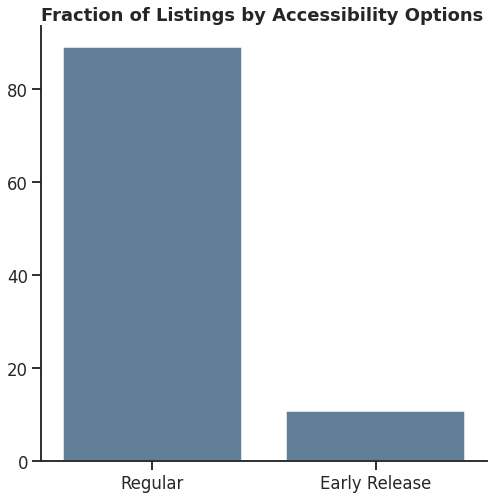

In [22]:
with sns.axes_style("ticks"):
    ax = sns.barplot(
        x="index",
        y="Early Access Release Date",
        data=df_early_release,
        color="steelblue",
        saturation=0.5,
    )
    ax.set_title(
        "Fraction of Listings by Accessibility Options", loc="left", fontweight="bold"
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "1_access_time.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

<a id="platforms"></a>

### 4.2. [Platforms](#platforms)

**What fraction of games are supported on all platforms?**

In [23]:
platforms_wanted = ["win", "mac", "linux"]

In [24]:
for platform in platforms_wanted:
    df[platform] = df["platforms"].str.contains(platform)

In [25]:
all_platforms = df[(df["linux"] == True) & ((df["mac"] == True)) & (df["win"] == True)]
print(
    f"Fraction of games with support on all platforms = "
    f"{(len(all_platforms) / len(df)) * 100:.2f}"
)

Fraction of games with support on all platforms = 20.80


**Plot the fraction of all listings that are supported on each platform?**

Reshape the original data, using the added columns (`win`, `mac`, `linux`)

In [26]:
listings_platforms_reshaped = (
    df[["win", "mac", "linux", "url"]]
    .set_index("url")
    .unstack()
    .reset_index()
    .rename(columns={0: "has_support", "level_0": "platform"})
)
listings_platforms_reshaped = listings_platforms_reshaped[
    listings_platforms_reshaped["has_support"] == True
]
display(listings_platforms_reshaped.head(10))

,platform,url,has_support
0,win,https://store.steampowered.com/app/1158940/Bla...,True
1,win,https://store.steampowered.com/app/21130/LEGO_...,True
2,win,https://store.steampowered.com/app/1315610/Sou...,True
3,win,https://store.steampowered.com/app/1585910/Roll/,True
4,win,https://store.steampowered.com/app/1372320/Clo...,True
5,win,https://store.steampowered.com/app/1535610/Sou...,True
6,win,https://store.steampowered.com/app/1105510/Yak...,True
7,win,https://store.steampowered.com/app/826940/Maid...,True
8,win,https://store.steampowered.com/app/718670/Cult...,True
9,win,https://store.steampowered.com/app/1356670/Sak...,True


Get the number of listings that are either listed as unsupported on a given platform or for which there is a missing value for the same platform

In [27]:
unsupported_missing_val = {}
for p in ["win", "mac", "linux"]:
    unsupported_missing_val[p] = df[df[p] == False].shape[0] + df[p].isna().sum()
print(unsupported_missing_val)

{'win': 45, 'mac': 6459, 'linux': 7695}


In [28]:
df_unsupported_missing_val = pd.DataFrame.from_dict(
    unsupported_missing_val, orient="index"
).reset_index()
df_unsupported_missing_val.columns = ["platform", "num_unsupported_and_missing"]
display(df_unsupported_missing_val)

,platform,num_unsupported_and_missing
0,win,45
1,mac,6459
2,linux,7695


Get the number of listings supported by a given platform

In [29]:
df_supported = (
    listings_platforms_reshaped.groupby("platform")["url"]
    .count()
    .reset_index()
    .rename(columns={"url": "num_listings"})
    .assign(num_rows=len(df))
)

Merge number of listings supported and those for which support is not available or unlisted, by platform

In [30]:
df_supported = df_supported.merge(
    df_unsupported_missing_val, on="platform", how="inner"
)

Calculate the fraction of supported adn unsupported/unlisted listings as a percentage

In [31]:
df_supported["pct_support"] = (
    df_supported["num_listings"] / df_supported["num_rows"]
) * 100
df_supported["platform"] = (
    df_supported["platform"]
    .str.title()
    .str.replace("Mac", "Mac OS")
    .str.replace("Win", "Windows")
)
display(df_supported)

,platform,num_listings,num_rows,num_unsupported_and_missing,pct_support
0,Linux,2340,10035,7695,23.318386
1,Mac OS,3576,10035,6459,35.635277
2,Windows,9990,10035,45,99.551570


Plot fractions on a chart

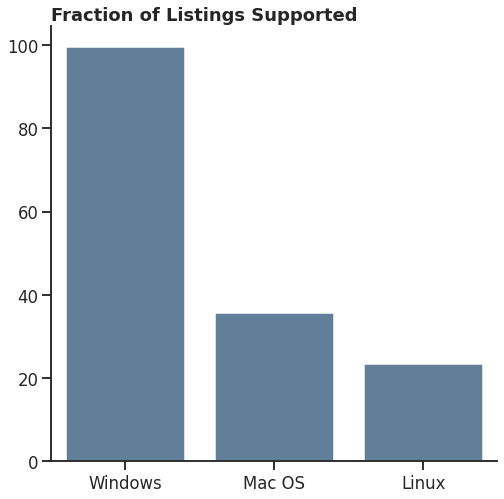

In [32]:
with sns.axes_style("ticks"):
    ax = sns.barplot(
        y="pct_support",
        x="platform",
        data=df_supported.sort_values(by="pct_support", ascending=False),
        color="steelblue",
        saturation=0.5,
    )
    ax.set_title("Fraction of Listings Supported", loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "2_platforms.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

<a id="franchises"></a>

### 4.3. [Franchises](#franchises)

**What fraction of games are part of by a Franchise?**

In [33]:
def calculate_frac_part_of_franchise(df):
    no_franchise = (len(df) - df["Franchise"].isna().sum()) / len(df)
    print(
        f"Number of games part of a Franchise = {100 * no_franchise:.2f}\n"
        f"Number of games not part of a franchise = {100*(1 - no_franchise):.2f}"
    )

In [34]:
calculate_frac_part_of_franchise(df)

Number of games part of a Franchise = 33.80
Number of games not part of a franchise = 66.20


**What fraction of games on each platform are part of a Franchise?**

In [35]:
calculate_frac_part_of_franchise(df[df["win"] == True])

Number of games part of a Franchise = 33.69
Number of games not part of a franchise = 66.31


In [36]:
calculate_frac_part_of_franchise(df[df["mac"] == True])

Number of games part of a Franchise = 31.96
Number of games not part of a franchise = 68.04


In [37]:
calculate_frac_part_of_franchise(df[df["linux"] == True])

Number of games part of a Franchise = 31.79
Number of games not part of a franchise = 68.21


<a id="publishers-and-platforms"></a>

### 4.4. [Publishers and Platforms](#publishers-and-platforms)

**What fraction of Linux games are offered through a publisher? What is the fraction without a publisher?**

In [38]:
linux_by_pubs = len(df[(df["linux"] == True) & (~df["Publisher"].isna())])
print(
    "Fraction of listings by a publisher with Linux support = "
    f"{(linux_by_pubs / len(df)) * 100:.3f}"
)
linux_no_pubs = len(df[(df["linux"] == True) & (df["Publisher"].isna())])
print(
    "Fraction of listings without a publisher with Linux support = "
    f"{(linux_no_pubs / len(df)) * 100:.3f}"
)

Fraction of listings by a publisher with Linux support = 23.229
Fraction of listings without a publisher with Linux support = 0.090


**What fraction of all games on all platforms are offered through a publisher? What is the fraction without a publisher?**

Calculate the fraction of listings by platform with and without a publisher
- with a publisher
  - the `Publisher` column is not missing a value
- without a publisher
  - the `Publisher` column is missing a value

In [39]:
d_platform_pub = {}
for p in ["win", "mac", "linux"]:
    d_platform_pub[p + "__True"] = (
        len(df[(df[p] == True) & (~df["Publisher"].isna())]) / len(df)
    ) * 100
    d_platform_pub[p + "__False"] = (
        len(df[(df[p] == True) & (df["Publisher"].isna())]) / len(df)
    ) * 100
df_platform_pub = (
    pd.DataFrame.from_dict(d_platform_pub, orient="index")
    .reset_index()
    .rename(columns={0: "pct_of_all_listings"})
)
display(df_platform_pub)

,index,pct_of_all_listings
0,win__True,99.192825
1,win__False,0.358744
2,mac__True,35.465869
3,mac__False,0.169407
4,linux__True,23.228700
5,linux__False,0.089686


Split the `index` column into `platform` and `publisher`

In [40]:
df_platform_pub[["platform", "publisher"]] = df_platform_pub["index"].str.split(
    "__", expand=True
)
df_platform_pub["publisher"] = df_platform_pub["publisher"].map(
    {"True": "Yes", "False": "No"}
)
df_platform_pub["platform"] = (
    df_platform_pub["platform"]
    .str.title()
    .str.replace("Mac", "Mac OS")
    .str.replace("Win", "Windows")
)
display(df_platform_pub)

,index,pct_of_all_listings,platform,publisher
0,win__True,99.192825,Windows,Yes
1,win__False,0.358744,Windows,No
2,mac__True,35.465869,Mac OS,Yes
3,mac__False,0.169407,Mac OS,No
4,linux__True,23.228700,Linux,Yes
5,linux__False,0.089686,Linux,No


Plot the fractions of listings through a publisher, by platform

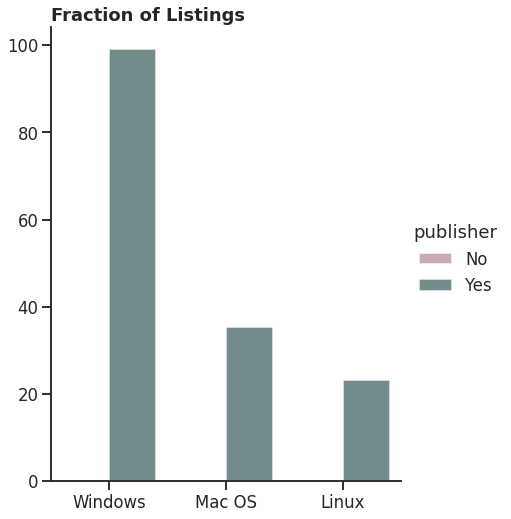

In [41]:
with sns.axes_style("ticks"):
    ax = sns.catplot(
        data=df_platform_pub.sort_values(by="publisher"),
        kind="bar",
        x="platform",
        y="pct_of_all_listings",
        hue="publisher",
        palette="husl",
        alpha=0.9,
        height=6,
        saturation=0.25,
    )
    ax.despine(left=True)
    ax = plt.gca()
    ax.set_title("Fraction of Listings", loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "3_platforms_publishers.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

The ratio of istings in each platform going through a publisher to those not going through one is shown below

In [42]:
d_relative_pub_no_pub = {}
for p in ["Windows", "Mac OS", "Linux"]:
    thru_pubs = df_platform_pub[
        (df_platform_pub["platform"] == p) & (df_platform_pub["publisher"] == "Yes")
    ]["pct_of_all_listings"].iloc[0]
    no_pubs = df_platform_pub[
        (df_platform_pub["platform"] == p) & (df_platform_pub["publisher"] == "No")
    ]["pct_of_all_listings"].iloc[0]
    d_relative_pub_no_pub[p + "_ratio__pub_no_pub"] = thru_pubs / no_pubs
df_relative_pub_no_pub = pd.DataFrame.from_dict(d_relative_pub_no_pub, orient="index").T
display(df_relative_pub_no_pub)

,Windows_ratio__pub_no_pub,Mac OS_ratio__pub_no_pub,Linux_ratio__pub_no_pub
0,276.5,209.352941,259.0


**Observations**
1. Linux-compatible games require expertise due to the dearth of drivers/software to allow a Linux system to support a game. This expertise is more likely to be found at a publishing company than through a standalone developer.

<a id="publishers-and-early-access-listings"></a>

### 4.5. [Publishers and Early Access listings](#publishers-and-early-access-listings)

In [43]:
print(df["Publisher"].isna().sum())

36


**What fraction of early-access games are offered through a publisher? What is the fraction without a publisher?**

Count the number of listings with early access with and without a publisher
- early access, without a publisher
  - the `Publisher` column is missing a value
  - the `Early Access...` column is not missing a value
- early access, with a publisher
  - the `Publisher` column is not missing a value
  - the `Early Access...` column is not missing a value
- no early access, without a publisher
  - the `Publisher` column is missing a value
  - the `Early Access...` column is missing a value
- no early access, with a publisher
  - the `Publisher` column is not missing a value
  - the `Early Access...` column is missing a value

In [44]:
early_access_no_pubs = len(
    df[(~df["Early Access Release Date"].isna()) & (df["Publisher"].isna())]
)
early_access_pubs = len(
    df[(~df["Early Access Release Date"].isna()) & (~df["Publisher"].isna())]
)
no_early_access_no_pubs = len(
    df[(df["Early Access Release Date"].isna()) & (df["Publisher"].isna())]
)
no_early_access_pubs = len(
    df[(df["Early Access Release Date"].isna()) & (~df["Publisher"].isna())]
)

Convert each count of listings to a fraction

In [45]:
d_no_early_acc_pubs = {
    "no_early_access__no_pubs": (no_early_access_no_pubs / len(df)) * 100,
    "no_early_access__pubs": (no_early_access_pubs / len(df)) * 100,
}
d_early_acc_pubs = {
    "early_access__no_pubs": (early_access_no_pubs / len(df)) * 100,
    "early_access__pubs": (early_access_pubs / len(df)) * 100,
}

Put all fractions into `DataFrame`s

In [46]:
df_no_early_acc_pubs = (
    pd.DataFrame.from_dict(d_no_early_acc_pubs, orient="index")
    .reset_index()
    .rename(columns={0: "pct_of_all_listings"})
)
df_early_acc_pubs = (
    pd.DataFrame.from_dict(d_early_acc_pubs, orient="index")
    .reset_index()
    .rename(columns={0: "pct_of_all_listings"})
)
display(df_no_early_acc_pubs)
display(df_early_acc_pubs)

,index,pct_of_all_listings
0,no_early_access__no_pubs,0.308919
1,no_early_access__pubs,88.769307


,index,pct_of_all_listings
0,early_access__no_pubs,0.049826
1,early_access__pubs,10.871948


Split `index` column of `DataFrame`s

In [47]:
df_no_early_acc_pubs[["early_access", "publisher"]] = df_no_early_acc_pubs[
    "index"
].str.split("__", expand=True)
df_early_acc_pubs[["early_access", "publisher"]] = df_early_acc_pubs["index"].str.split(
    "__", expand=True
)
display(df_no_early_acc_pubs)
display(df_early_acc_pubs)

,index,pct_of_all_listings,early_access,publisher
0,no_early_access__no_pubs,0.308919,no_early_access,no_pubs
1,no_early_access__pubs,88.769307,no_early_access,pubs


,index,pct_of_all_listings,early_access,publisher
0,early_access__no_pubs,0.049826,early_access,no_pubs
1,early_access__pubs,10.871948,early_access,pubs


Vertically concatenate `DataFrame`s

In [48]:
df_early_no_early_acc_pubs = pd.concat([df_early_acc_pubs, df_no_early_acc_pubs])
df_early_no_early_acc_pubs["early_access"] = df_early_no_early_acc_pubs[
    "early_access"
].map({"early_access": "Early Access", "no_early_access": "No Early Access"})
df_early_no_early_acc_pubs["publisher"] = df_early_no_early_acc_pubs["publisher"].map(
    {"pubs": "Yes", "no_pubs": "No"}
)
display(df_early_no_early_acc_pubs)

,index,pct_of_all_listings,early_access,publisher
0,early_access__no_pubs,0.049826,Early Access,No
1,early_access__pubs,10.871948,Early Access,Yes
0,no_early_access__no_pubs,0.308919,No Early Access,No
1,no_early_access__pubs,88.769307,No Early Access,Yes


Plot fractions

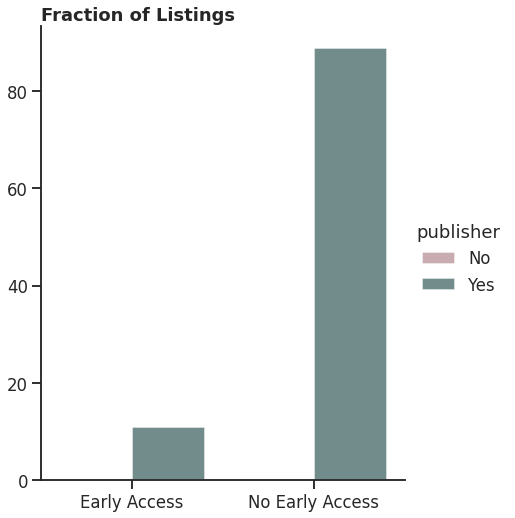

In [49]:
with sns.axes_style("ticks"):
    ax = sns.catplot(
        data=df_early_no_early_acc_pubs,
        kind="bar",
        x="early_access",
        y="pct_of_all_listings",
        hue="publisher",
        palette="husl",
        alpha=0.9,
        height=6,
        saturation=0.25,
    )
    ax.despine(left=True)
    # ax.set_axis_labels("", "Early Access Listings through a Publisher")
    ax = plt.gca()
    ax.set_title("Fraction of Listings", loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "4_publisher_early_release.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

(OPTIONAL) Calculate the ratio of listings with a publisher to those without a publisher, depending on whether or not they support early-access

In [50]:
pub_no_early = (df_early_no_early_acc_pubs["publisher"] == "Yes") & (
    df_early_no_early_acc_pubs["early_access"] == "No Early Access"
)
pub_early = (df_early_no_early_acc_pubs["publisher"] == "Yes") & (
    df_early_no_early_acc_pubs["early_access"] == "Early Access"
)
no_pub_no_early = (df_early_no_early_acc_pubs["publisher"] == "No") & (
    df_early_no_early_acc_pubs["early_access"] == "No Early Access"
)
no_pub_early = (df_early_no_early_acc_pubs["publisher"] == "No") & (
    df_early_no_early_acc_pubs["early_access"] == "Early Access"
)

d_relative_pub_no_pub_for_early_acc = {
    "No Early Access": (
        df_early_no_early_acc_pubs[pub_no_early]["pct_of_all_listings"].iloc[0]
        / df_early_no_early_acc_pubs[no_pub_no_early]["pct_of_all_listings"].iloc[0]
    ),
    "Early Access": (
        df_early_no_early_acc_pubs[pub_early]["pct_of_all_listings"].iloc[0]
        / df_early_no_early_acc_pubs[no_pub_early]["pct_of_all_listings"].iloc[0]
    ),
}
df_relative_pub_no_pub_for_early_acc = pd.DataFrame.from_dict(
    d_relative_pub_no_pub_for_early_acc, orient="index"
).rename(columns={0: "ratio_pub__no_pub"})
display(df_relative_pub_no_pub_for_early_acc)

,ratio_pub__no_pub
No Early Access,287.354839
Early Access,218.200000


<a id="publishers-and-multi-language-support"></a>

### 4.6. [Publishers and Multi-Language Support](#publishers-and-multi-language-support)

**What fraction of multi-language supported listings are offered through a publisher? What is the fraction without going through a publisher?**

In [51]:
multi_lang_pubs = len(df[(df["num_languages"] > 1) & (~df["Publisher"].isna())])
print(
    "Fraction of listings with multi-language support that are "
    f"offered by a publisher = {(multi_lang_pubs / len(df)) * 100:.2f}"
)

Fraction of listings with multi-language support that are offered by a publisher = 63.82


In [52]:
multi_lang_no_pubs = len(df[(df["num_languages"] > 1) & (df["Publisher"].isna())])
print(
    "Fraction of listings with multi-language support that are not "
    f"offered by a publisher = {(multi_lang_no_pubs / len(df)) * 100:.2f}"
)

Fraction of listings with multi-language support that are not offered by a publisher = 0.24


<a id="developers"></a>

### 4.7. [Developers](#developers)

**Show a table with each of the top 15 developers by the number of listings they support on Windows. Include the number of their supported listings on mac and linux as well. For any occurrences where multiple developers collaborated, consider each separately.**

For every listing, get the developer and a separate row showing each supported platform

In [53]:
def extract_platforms_counts(data):
    return pd.DataFrame.from_dict(
        {
            "win_support": (data["platform"] == "win").sum(),
            "mac_support": (data["platform"] == "mac").sum(),
            "linux_support": (data["platform"] == "linux").sum(),
        },
        orient="index",
    ).T

In [54]:
%%time
df_platforms = (
    df[[p for p in platforms_wanted] + ["url", "Developer"]]
    .set_index(["url", "Developer"])
    .stack()
    .reset_index()
    .rename(columns={"level_2": "platform", 0: "support"})
    .astype({"Developer": "str"})
    .sort_values(by=["url"], ascending=True)
    .query("support == True")
)
show_df(df_platforms, 5)

,url,Developer,platform,support
1833,https://store.steampowered.com/app/1000010/Crown_Trick/,NEXT Studios,win,True
1866,https://store.steampowered.com/app/1000030/Cook_Serve_Delicious_3/,Vertigo Gaming Inc.,win,True
1867,https://store.steampowered.com/app/1000030/Cook_Serve_Delicious_3/,Vertigo Gaming Inc.,mac,True
19633,https://store.steampowered.com/app/1000080/Zengeon/,IndieLeague Studio,mac,True
19632,https://store.steampowered.com/app/1000080/Zengeon/,IndieLeague Studio,win,True
333,https://store.steampowered.com/app/99900/Spiral_Knights/,"Grey Havens, LLC",win,True
334,https://store.steampowered.com/app/99900/Spiral_Knights/,"Grey Havens, LLC",mac,True
93,https://store.steampowered.com/app/99910/Puzzle_Pirates/,"Grey Havens, LLC",win,True
94,https://store.steampowered.com/app/99910/Puzzle_Pirates/,"Grey Havens, LLC",mac,True
8202,https://store.steampowered.com/app/999660/SAMURAI_SHODOWN_NEOGEO_COLLECTION/,DIGITAL ECLIPSE,win,True


CPU times: user 48.6 ms, sys: 101 µs, total: 48.7 ms
Wall time: 47.9 ms


Aggregate over each developer and count the number of their listings with support for each of the platforms (sorting results based on the number Windows listings)

In [55]:
%%time
df_platforms_by_developer = (
    df_platforms.groupby("Developer").apply(
        extract_platforms_counts
    ).reset_index(level=1, drop=True).nlargest(15, "win_support")
)
show_df(df_platforms_by_developer, 5)

,win_support,mac_support,linux_support
Developer,,,
Choice of Games,44,44,44
Humongous Entertainment,33,30,30
HeR Interactive,30,6,0
Winged Cloud,29,16,25
Hosted Games,27,27,27
Quiet River,21,0,0
Daedalic Entertainment,18,14,11
Minimol Games,17,14,0
Nihon Falcom,16,0,0


CPU times: user 5.02 s, sys: 143 ms, total: 5.17 s
Wall time: 4.77 s


<a id="digital-rights-management"></a>

### 4.8. [Digital Rights Management](#digital-rights-management)

**What fraction of listings doesn't involve a DRM?**

We'll assume that a missing value in the DRM column indicates that a DRM is not required

In [56]:
drm_missing_frac = (df["drm"].isna().sum() / len(df)) * 100
print(f"Fraction of listings without a DRM = {drm_missing_frac:.2f}")

Fraction of listings without a DRM = 88.23


**Observations**
1. Some games are free of DRMs ([1](https://www.digitaltrends.com/gaming/what-is-drm-in-video-games/)), but taking missing values in this column as being valid results in quite a large fraction of listings that don't require a DRM. We likely can't draw too many conclusions about this dataset that involves use of this column.

**What are the top 10 Genres that includes a DRM?**

In [57]:
drm_reqd = df[df["drm"].isna()]
listings_by_genre = (
    drm_reqd.groupby("Genre", as_index=False)["url"].count().nlargest(10, "url")
)
show_df(listings_by_genre)

,Genre,url
348,"Adventure, Indie",550
217,"Action, Indie",494
86,"Action, Adventure, Indie",423
0,Action,364
419,"Casual, Indie",356
301,"Adventure, Casual, Indie",353
287,Adventure,294
355,"Adventure, Indie, RPG",202
155,"Action, Casual, Indie",199
96,"Action, Adventure, Indie, RPG",194


<a id="genres-and-user-defined-tags"></a>

### 4.9. [Genres and User-Defined Tags](#genres-and-user-defined-tags)

**What fraction of listings are missing a Genre? a user-defined tag?**

In [58]:
genre_missing = (df["Genre"].isna().sum() / len(df)) * 100
tag_missing = (df["user_defined_tags"].isna().sum() / len(df)) * 100
print(
    f"Fraction of listings without a Genre = {genre_missing:.2f}, "
    f"without a User-Defined Tag = {tag_missing:.2f}"
)

Fraction of listings without a Genre = 0.12, without a User-Defined Tag = 0.00


**How many Genres are covered by the retrieved listings?**

In [59]:
print(f"Number of unique Genres in the scraped data = {df['Genre'].nunique():,}")

Number of unique Genres in the scraped data = 660


**Reshape the data to have all Genres as separate rows for a given listing**

Create a [messy dataset](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) showing URL and Genre
- for each listing, this will split all the genres from a single row to having a single genre per row

In [60]:
%%time
df_genres_messy = (
    df["Genre"]
    .str.split(", ", expand=True)
    .assign(url=df["url"])
    .set_index("url")
    .unstack()
    .reset_index()
    .drop(columns=["level_0"])
    .dropna()
    .rename(columns={0: "Genre"})
)
show_df(df_genres_messy, 5)

,url,Genre
0,https://store.steampowered.com/app/1158940/Blazing_Sails/,Action
1,https://store.steampowered.com/app/21130/LEGO_Harry_Potter_Years_14/,Action
2,https://store.steampowered.com/app/1315610/Source_of_Madness/,Action
3,https://store.steampowered.com/app/1585910/Roll/,Casual
4,https://store.steampowered.com/app/1372320/Cloud_Gardens/,Casual
98072,https://store.steampowered.com/app/1396890/Boss_of_this_gym/,Sports
103229,https://store.steampowered.com/app/1048100/Peekaboo_Online_Hide_and_Seek/,Strategy
106431,https://store.steampowered.com/app/1514690/Peekaboo_Lite_Prop_Hunt/,Strategy
108107,https://store.steampowered.com/app/1396890/Boss_of_this_gym/,Strategy
116466,https://store.steampowered.com/app/1514690/Peekaboo_Lite_Prop_Hunt/,Early Access


CPU times: user 161 ms, sys: 6.95 ms, total: 168 ms
Wall time: 167 ms


Aggregate over Genre and count the number of listings

In [61]:
%%time
df_genres_messy_grouped = (
    df_genres_messy.groupby("Genre", as_index=False)["url"]
    .count()
    .sort_values(by="url", ascending=False)
)
display(df_genres_messy_grouped)

,Genre,url
5,Indie,6582
1,Adventure,4178
0,Action,3978
2,Casual,3118
11,Strategy,2340
9,Simulation,2220
7,RPG,2131
3,Early Access,818
4,Free to Play,502
10,Sports,458


CPU times: user 9 ms, sys: 219 µs, total: 9.21 ms
Wall time: 8.36 ms


Plot the aggregation output

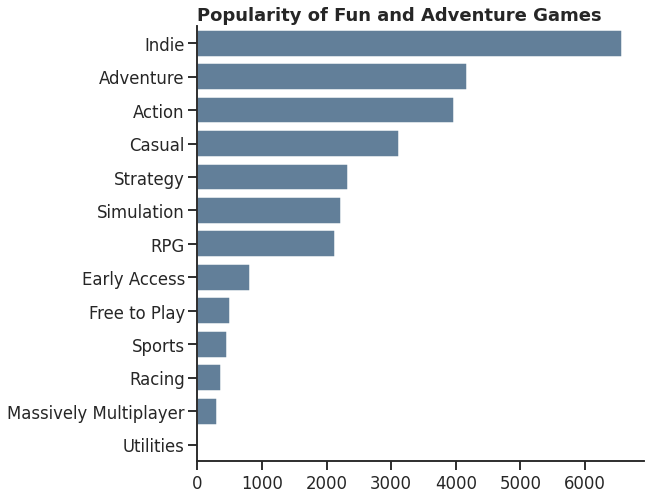

In [62]:
with sns.axes_style("ticks"):
    ax = sns.barplot(
        y="Genre",
        x="url",
        data=df_genres_messy_grouped,
        color="steelblue",
        saturation=0.5,
    )
    ax.set_title("Popularity of Fun and Adventure Games", loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "5_genres.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

**Count the number of listings with exactly 20 tags (the maximum allowed on the Steam store) and less than 20 tags.**

Reshape the data to have all tags as separate rows for a given listing.

Get a list of all unique tags for a given listing

In [63]:
%%time
df["num_tags"] = (
    df["user_defined_tags"]
    .dropna()
    .str.split(", ", expand=False)
    .apply(lambda x: len(x))
)
show_df(df[["user_defined_tags", "num_tags"]], 5)

,user_defined_tags,num_tags
0,"Early Access, Co-op, Naval Combat, Online Co-Op, Character Customization, FPS, Pirates, Historical, Open World, PvP, Fast-Paced, Battle Royale, First-Person, Survival, Team-Based, Competitive, Funny, Shooter, Action, Naval",20
1,"LEGO, Adventure, Local Co-Op, Action, Magic, Family Friendly, Multiplayer, Singleplayer, Fantasy, Comedy, Split Screen, Open World, Funny, Puzzle, Co-op, Controller, Local Multiplayer, Third Person, 3D Platformer, Atmospheric",20
2,"Early Access, Action RPG, Lovecraftian, Action, Roguelite, Magic, Souls-like, 2D, Dark Fantasy, Atmospheric, Fantasy, Dark, Mystery, Action Roguelike, Action-Adventure, Combat, Procedural Generation, Singleplayer, Roguevania, Physics",20
3,"Deckbuilding, Strategy, Score Attack, Relaxing, Clicker, Procedural Generation, Minimalist, Replay Value, Casual, Modern, Choices Matter, Indie, Solitaire, Arcade, Family Friendly, 2D, Board Game, Resource Management, Singleplayer, Roguelike Deckbuilder",20
4,"Nature, Sandbox, Atmospheric, Experimental, Procedural Generation, Relaxing, Casual, Simulation, Building, Singleplayer, Surreal, Indie, Early Access, Level Editor, 3D, Post-apocalyptic, Short, City Builder, Family Friendly, Puzzle",20
10030,"Casual, Dating Sim, Romance, 2.5D, Cute, Pixel Graphics, Text-Based, Emotional, Visual Novel, Choices Matter, Multiple Endings, Conversation, Interactive Fiction, Choose Your Own Adventure, Relaxing, Story Rich, Linear, Colorful, Singleplayer, Indie",20
10031,"Action, Casual, Indie",3
10032,"Strategy, Turn-Based",2
10033,"Horror, Choose Your Own Adventure, Immersive Sim, Survival Horror, Life Sim, Visual Novel, Hidden Object, Interactive Fiction, Open World, Tabletop, Experimental, 2D, Comic Book, Cute, Isometric, Top-Down, Choices Matter, Linear, Narration, Procedural Generation",20
10034,"Survival, Simulation, Strategy, Indie, RPG, Adventure, Management, Crafting, Singleplayer, Casual, Resource Management",11


CPU times: user 30.7 ms, sys: 0 ns, total: 30.7 ms
Wall time: 30.5 ms


Count the number of listins with 20 or less than 20 tags

In [64]:
%%time
df_numtags_lt_twenty = (df["num_tags"] < 20).value_counts().reset_index()
df_numtags_lt_twenty["index"] = df_numtags_lt_twenty["index"].map(
    {True: "Less than 20", False: "20 (max. allowed)"}
)
show_df(df_numtags_lt_twenty)

,index,num_tags
0,Less than 20,5855
1,20 (max. allowed),4180


CPU times: user 3.91 ms, sys: 0 ns, total: 3.91 ms
Wall time: 3.17 ms


Plot the number of listings with 20 or less than 20 tags

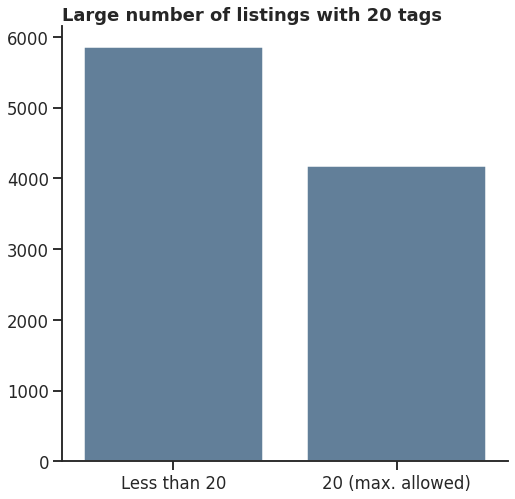

In [65]:
with sns.axes_style("ticks"):
    ax = sns.barplot(
        y="num_tags",
        x="index",
        data=df_numtags_lt_twenty,
        color="steelblue",
        saturation=0.5,
    )
    ax.set_title("Large number of listings with 20 tags", loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "6_user_defined_tags.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

**Observations**
1. A Steam listing can be assigned a [minimum of 5 tags and a maximum of 20](https://www.askgamedev.com/everything-we-know-about-steam-tags-2020/).

Plot the distribution of the number of tags

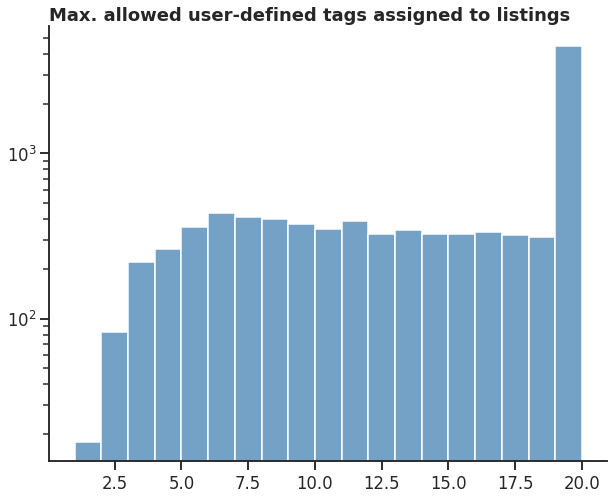

In [66]:
with sns.axes_style("ticks"):
    ax = sns.histplot(
        data=df[["num_tags"]],
        x="num_tags",
        log_scale=(False, True),
        color="steelblue",
    )
    ax.set_title(
        "Max. allowed user-defined tags assigned to listings",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(10)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "7_distribution_of_num_tags.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

<a id="ratings"></a>

### 4.10. [Ratings](#ratings)

**What fraction of listings are missing a rating?**

In [67]:
rating_missing = (df["rating"].isna().sum() / len(df)) * 100
print(f"Fraction of listings without a rating = {rating_missing:.2f}")

Fraction of listings without a rating = 76.59


**What are the possible ratings?**

We'll assign more human-readable names to the ratings

In [68]:
ratings_mapper = {
    "t": "Teen",
    "e": "Everyone",
    "m": "Mature",
    "rp": "Pending",
    "ec": "Early Childhood",
    "e10": "10 and Older",
    "ao": "Adults Only (18+)",
}

In [69]:
%%time
df_ratings = (
    df["rating"]
    .replace(ratings_mapper)
    .str.title()
    .fillna("No Rating")
    .value_counts(dropna=False)
    .reset_index()
    .rename(columns={"rating": "num_listings", "index": "rating"})
)
show_df(df_ratings)

,rating,num_listings
0,No Rating,7686
1,Teen,812
2,Everyone,615
3,Mature,491
4,10 And Older,395
5,Pending,27
6,Early Childhood,6
7,Adults Only (18+),3


CPU times: user 7.23 ms, sys: 0 ns, total: 7.23 ms
Wall time: 6.52 ms


Plot the number of listings by rating

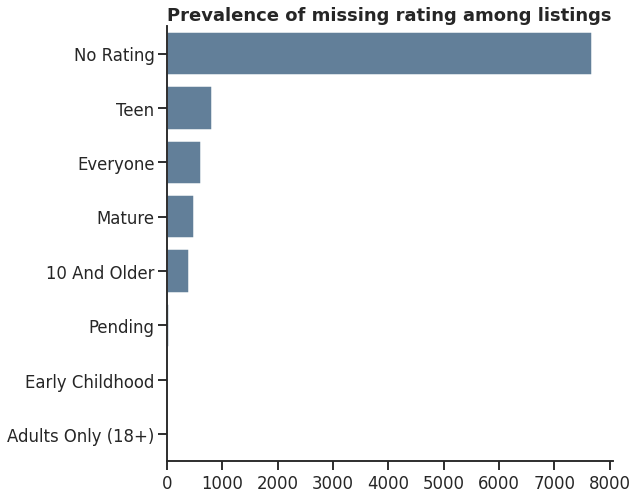

In [70]:
with sns.axes_style("ticks"):
    ax = sns.barplot(
        y="rating",
        x="num_listings",
        data=df_ratings,
        color="steelblue",
        saturation=0.5,
    )
    ax.set_title(
        "Prevalence of missing rating among listings",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    # fig.savefig(
    #     os.path.join(processed_data_dir, "8_listing_ratings.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

**What is the distribution of rating descriptors?**

Create a messy dataset showing URL and `rating_descriptors`

In [71]:
df_rd_messy = (
    df["rating_descriptors"]
    .str.replace(", ,", ",")
    .str.split(", ", expand=True)
    .assign(url=df["url"])
    .set_index("url")
    .unstack()
    .reset_index()
    .drop(columns=["level_0"])
    .dropna()
    .rename(columns={0: "rating_descriptor"})
)
show_df(df_rd_messy, 5)

,url,rating_descriptor
1,https://store.steampowered.com/app/21130/LEGO_Harry_Potter_Years_14/,Cartoon Violence
5,https://store.steampowered.com/app/1535610/Soul_Nomad__the_World_Eaters/,Fantasy Violence
6,https://store.steampowered.com/app/1105510/Yakuza_5_Remastered/,Blood
7,https://store.steampowered.com/app/826940/Maid_of_Sker/,Intense Violence
9,https://store.steampowered.com/app/1356670/Sakuna_Of_Rice_and_Ruin/,Fantasy Violence
64374,https://store.steampowered.com/app/361300/Mother_Russia_Bleeds/,Use of Drugs
64479,https://store.steampowered.com/app/461700/Seduce_Me_2_The_Demon_War/,Comic Mischief
66869,https://store.steampowered.com/app/2450/Bloody_Good_Time/,Violence
74514,https://store.steampowered.com/app/461700/Seduce_Me_2_The_Demon_War/,Crude Humor
84549,https://store.steampowered.com/app/461700/Seduce_Me_2_The_Demon_War/,Mature Humor


Aggregate by `rating_descriptor` and count the number of listings

In [72]:
%%time
df_rd_messy_grouped = (
    df_rd_messy.groupby("rating_descriptor", as_index=False)["url"]
    .count()
    .nlargest(20, "url")
)
show_df(df_rd_messy_grouped)

,rating_descriptor,url
168,Violence,662
26,Blood,436
62,Fantasy Violence,333
32,Blood and Gore,249
95,Mild Language,247
147,Strong Language,235
77,Language,210
154,Suggestive Themes,198
75,Intense Violence,149
141,Sexual Themes,126


CPU times: user 3.84 ms, sys: 2.63 ms, total: 6.47 ms
Wall time: 5.74 ms


Plot the number of listings by rating descriptor

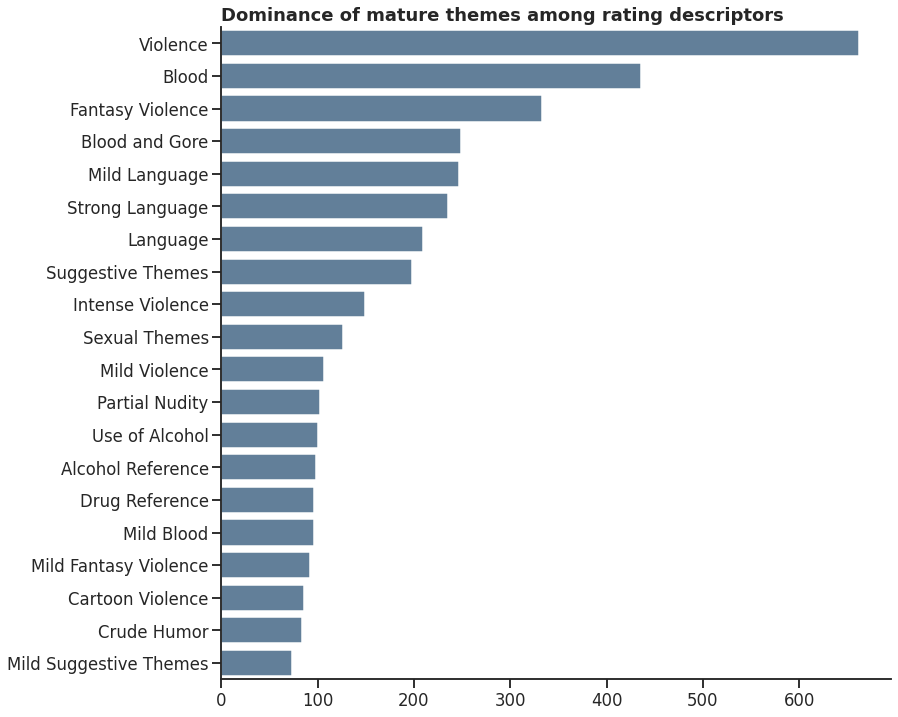

In [73]:
with sns.axes_style("ticks"):
    ax = sns.barplot(
        y="rating_descriptor",
        x="url",
        data=df_rd_messy_grouped,
        color="steelblue",
        saturation=0.5,
    )
    ax.set_title(
        "Dominance of mature themes among rating descriptors",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(12)
    fig.set_figwidth(12)
    # fig.savefig(
    #     os.path.join(processed_data_dir, "9_rating_descriptors.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

<a id="publishers"></a>

### 4.11. [Publishers](#publishers)

**Add a column with the number of publishers for each listing**

In [74]:
df["num_publishers"] = (
    df["Publisher_cleaned"].str.split(", ", expand=False).apply(lambda x: len(x))
)

**Count the number of listings by the single and multiple publishers**

Aggregate over the number of publishers and count the number of listings

In [75]:
df_num_pubs = df.groupby("num_publishers", as_index=False)["url"].count()
df_num_pubs["multiple_pubs"] = df_num_pubs["num_publishers"] > 1
show_df(df_num_pubs)

,num_publishers,url,multiple_pubs
0,1,9444,False
1,2,543,True
2,3,44,True
3,4,4,True


Count the number of listings for a single and multiple publishers

In [76]:
single_multi_pubs = df_num_pubs.groupby("multiple_pubs", as_index=False)["url"].sum()
single_multi_pubs["multiple_pubs"] = single_multi_pubs["multiple_pubs"].map(
    {True: "Multiple", False: "Single"}
)
show_df(single_multi_pubs)

,multiple_pubs,url
0,Single,9444
1,Multiple,591


Plot the number of listings for single and multiple publishers

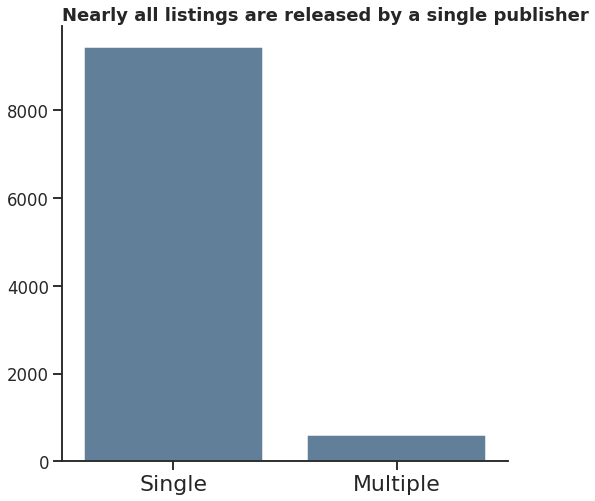

In [77]:
with sns.axes_style("ticks"):
    ax = sns.barplot(
        y="url",
        x="multiple_pubs",
        data=single_multi_pubs,
        color="steelblue",
        saturation=0.5,
    )
    ax.set_title(
        "Nearly all listings are released by a single publisher",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=22)
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "10_number_of_publishers.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

**What fraction of all available listings are offerred by a single publisher?**

In [78]:
frac_single_pub = (
    df_num_pubs[df_num_pubs["num_publishers"] == 1]["url"].iloc[0]
    / df_num_pubs["url"].sum()
) * 100
print(f"Fraction by a single publisher = {frac_single_pub:.2f}")

Fraction by a single publisher = 94.11


**For each listing, the cleaned publishers column has all publisher names on the same row. For each listing, get every publisher on separate row (i.e. create a messy dataset for URL and publisher).**

Split each publisher into a separate column, per listing

In [79]:
pubs_url = df["Publisher_cleaned"].str.split(", ", expand=True).assign(url=df["url"])
show_df(pubs_url, 5)

,0,1,2,3,url
0,iceberg interactive,None,None,None,https://store.steampowered.com/app/1158940/Blazing_Sails/
1,warner bros. interactive entertainment,None,None,None,https://store.steampowered.com/app/21130/LEGO_Harry_Potter_Years_14/
2,thunderful publishing,None,None,None,https://store.steampowered.com/app/1315610/Source_of_Madness/
3,joseph distler,None,None,None,https://store.steampowered.com/app/1585910/Roll/
4,noio,None,None,None,https://store.steampowered.com/app/1372320/Cloud_Gardens/
10030,way down deep,None,None,None,https://store.steampowered.com/app/1492480/Half Past Fate: Romantic Distancing/
10031,oukaein,None,None,None,https://store.steampowered.com/app/1144280/Ain Dodo/
10032,wargaming.net,None,None,None,https://store.steampowered.com/app/34640/Massive Assault: Phantom Renaissance/
10033,randumb studios,None,None,None,https://store.steampowered.com/app/1218570/The Twins/
10034,dear villagers,None,None,None,https://store.steampowered.com/app/384310/Dead In Bermuda/


Create a messy dataset of URL and publisher

In [80]:
pubs_url_reshaped = (
    pubs_url.set_index("url")
    .unstack()
    .reset_index()
    .drop(columns=["level_0"])
    .rename(columns={0: "Publisher_cleaned"})
    .dropna()
)
show_df(pubs_url_reshaped, 5)

,url,Publisher_cleaned
0,https://store.steampowered.com/app/1158940/Blazing_Sails/,iceberg interactive
1,https://store.steampowered.com/app/21130/LEGO_Harry_Potter_Years_14/,warner bros. interactive entertainment
2,https://store.steampowered.com/app/1315610/Source_of_Madness/,thunderful publishing
3,https://store.steampowered.com/app/1585910/Roll/,joseph distler
4,https://store.steampowered.com/app/1372320/Cloud_Gardens/,noio
29522,https://store.steampowered.com/app/1210490/YesterMorrow/,orenda (asia)
30879,https://store.steampowered.com/app/421020/DiRT_4/,electronic arts
31171,https://store.steampowered.com/app/515220/F1_2017/,electronic arts
36211,https://store.steampowered.com/app/589670/Double_Kick_Heroes/,kakehashi
39007,https://store.steampowered.com/app/41740/Cargo_The_Quest_for_Gravity/,nordic games


**How many unique publishers contribute games?**

In [81]:
print(
    f"{pubs_url_reshaped['Publisher_cleaned'].nunique():,} publishers contributed listings"
)

4,804 publishers contributed listings


**Create a list of well-known video game publishers and count the number of listings by each of them.**
- Lists of well-known publishers ([1](https://en.wikipedia.org/wiki/Video_game_publisher), [2](), [3](https://www.alltopeverything.com/top-10-biggest-video-game-companies/), [4](https://dfdnews.com/2021/04/23/2021-console-and-pc-game-publisher-sales-report-spend-grew-36-across-all-publishers-over-2020/))

In [82]:
top_pubs = [
    "sony",
    "tencent",
    "activision",
    "electronic",
    "bandai",
    "microsoft",
    "netease",
    "rockstar",
    "valve",
    "ubisoft",
    "apple",
    "insomniac",
    "epic",
    "take-two",
    "aquaplus",
]

Filter the cleaned publisher column to only include rows for the above list of publishers

In [83]:
%%time
df_well_pubs_url_reshaped = pubs_url_reshaped[
    pubs_url_reshaped["Publisher_cleaned"].str.contains("|".join(top_pubs))
]
show_df(df_well_pubs_url_reshaped, 5)

,url,Publisher_cleaned
11,https://store.steampowered.com/app/204100/Max_Payne_3/,rockstar games
24,https://store.steampowered.com/app/551170/Onmyoji/,netease games
50,https://store.steampowered.com/app/798460/Ni_no_Kuni_Wrath_of_the_White_Witch_Remastered/,bandai namco entertainment
79,https://store.steampowered.com/app/738540/Tales_of_Vesperia_Definitive_Edition/,bandai namco entertainment
89,https://store.steampowered.com/app/24790/Command__Conquer_3_Tiberium_Wars/,electronic arts
16016,https://store.steampowered.com/app/3350/Bejeweled_Deluxe/,electronic arts
16176,https://store.steampowered.com/app/12770/Rise_of_the_Argonauts/,electronic arts
22850,https://store.steampowered.com/app/391040/F1_2016/,electronic arts
30879,https://store.steampowered.com/app/421020/DiRT_4/,electronic arts
31171,https://store.steampowered.com/app/515220/F1_2017/,electronic arts


CPU times: user 10.9 ms, sys: 945 µs, total: 11.9 ms
Wall time: 11.5 ms


Count the number of listings associated with the above specified list of publishers

In [84]:
df_num_listings_by_known_pubs = (
    df_well_pubs_url_reshaped.groupby("Publisher_cleaned", as_index=False)["url"]
    .count()
    .rename(columns={"url": "num_listings"})
    .nlargest(20, "num_listings")
)
show_df(df_num_listings_by_known_pubs)

,Publisher_cleaned,num_listings
22,ubisoft,67
7,electronic arts,53
4,bandai namco entertainment,44
1,activision,30
24,valve,12
10,epic games inc.,5
18,netease games,4
0,@unepic_fran,3
20,rockstar games,3
23,ubisoft entertainment,3


**Find the top 21 publishers overall (exclude collaborations between publishers)**

In [85]:
df_num_listings_by_all_pubs = (
    pubs_url_reshaped.groupby("Publisher_cleaned", as_index=False)["url"]
    .count()
    .rename(columns={"url": "num_listings"})
)
df_num_listings_by_all_pubs["Publisher_cleaned"] = df_num_listings_by_all_pubs[
    "Publisher_cleaned"
].str.title()
show_df(df_num_listings_by_all_pubs.nlargest(21, "num_listings"))

,Publisher_cleaned,num_listings
4260,Thq Nordic,103
3945,Square Enix,79
3722,Sekai Project,76
1142,Disney,68
4417,Ubisoft,67
2918,Nightdive Studios,65
2224,Kagura Games,63
361,Artifex Mundi,62
1095,Devolver Digital,61
3277,Playism,59


Plot the number of listings by the top 21 publishers

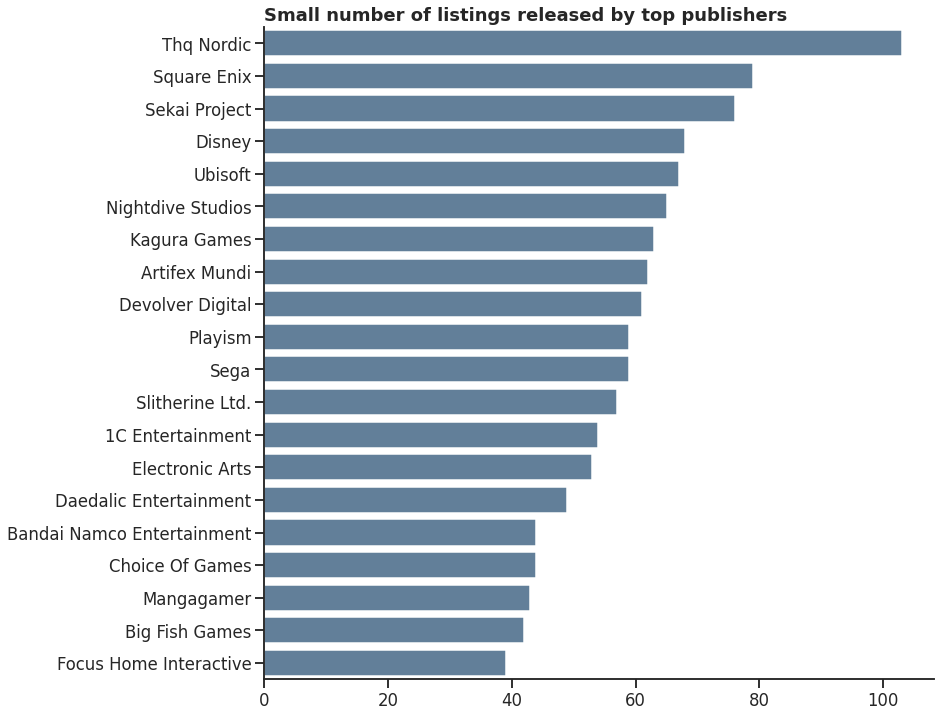

In [86]:
with sns.axes_style("ticks"):
    ax = sns.barplot(
        y="Publisher_cleaned",
        x="num_listings",
        data=df_num_listings_by_all_pubs.nlargest(20, "num_listings"),
        color="steelblue",
        saturation=0.5,
    )
    ax.set_title(
        "Small number of listings released by top publishers",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(12)
    fig.set_figwidth(12)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "11_top_publishers_by_num_listings.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

<a id="user-rating"></a>

### 4.12. [User Rating](#user-rating)

**Find the top 10 publishers with the most number of Very Positive user-ratings**

Merge the reshaped publishers `DataFrame` with the original data

In [87]:
pubs_url_reshaped_rating = pubs_url_reshaped.merge(
    df[["url", "overall_review_rating"]], on="url", how="left"
)
display(pubs_url_reshaped_rating.sample(10))

,url,Publisher_cleaned,overall_review_rating
4752,https://store.steampowered.com/app/508980/Cras...,2tainment gmbh,Very Positive
5108,https://store.steampowered.com/app/252150/Grimm/,spicyhorse games,Very Positive
8638,https://store.steampowered.com/app/1000470/Dra...,darkdes labs,Very Positive
7707,https://store.steampowered.com/app/298560/Capt...,pixelsaurus games,Mostly Positive
10658,https://store.steampowered.com/app/795760/UPPERS/,marvelous usa inc.,Very Positive
10321,https://store.steampowered.com/app/680030/Gone...,surefire.games,Positive
9917,https://store.steampowered.com/app/1026380/Ove...,battlesquatch,Mostly Positive
5598,https://store.steampowered.com/app/585180/Open...,open sorcery games,Very Positive
7629,https://store.steampowered.com/app/58570/The_N...,focus home interactive,Very Positive
9361,https://store.steampowered.com/app/1011830/Roc...,openlab games,Very Positive


Get the top 10 publishers as required

In [88]:
df_user_ratings = (
    df.groupby("overall_review_rating", as_index=False)["url"]
    .count()
    .sort_values(by="url", ascending=False)
)
df_user_ratings = df_user_ratings[
    df_user_ratings["overall_review_rating"].str.contains("Positive|Negative")
]
df_user_ratings["positive"] = df_user_ratings["overall_review_rating"].str.contains(
    "Positive"
)
display(df_user_ratings)

,overall_review_rating,url,positive
10,Very Positive,5551,True
5,Mostly Positive,1622,True
8,Positive,1388,True
7,Overwhelmingly Positive,146,True
4,Mostly Negative,23,False
9,Very Negative,3,False
6,Overwhelmingly Negative,1,False


**Notes**
1. The user-ratings distribution is skewed. There are almost no negative ratings for the scraped listings. This might not a good question to ask. There might be other issues related to the user rating on Steam if they are almost all very positive.

Get the total number of ratings that are positive and those that are not positive

In [89]:
df_user_ratings_grouped = df_user_ratings.groupby("positive", as_index=False)[
    "url"
].sum()
df_user_ratings_grouped["positive"] = (
    df_user_ratings_grouped["positive"].replace(True, "Yes").replace(False, "No")
)
display(df_user_ratings_grouped)

,positive,url
0,No,27
1,Yes,8707


Plot a chart of the total number of positive and non-positive ratings

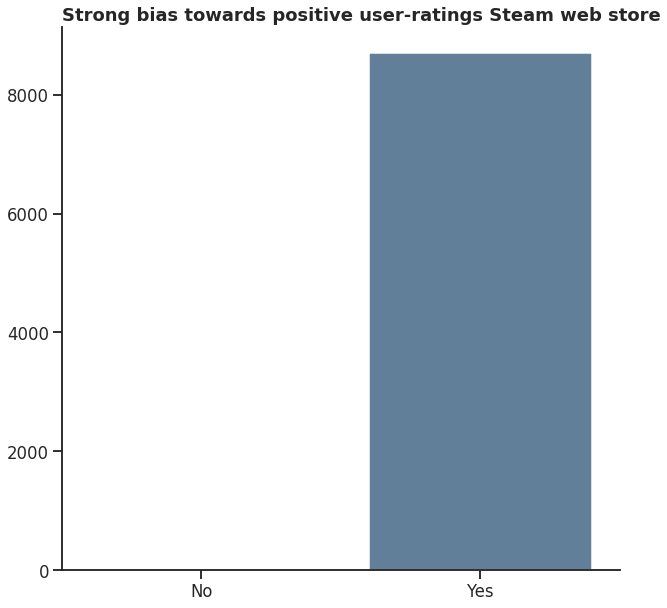

In [90]:
with sns.axes_style("ticks"):
    ax = sns.barplot(
        y="url",
        x="positive",
        data=df_user_ratings_grouped.groupby("positive", as_index=False)["url"].sum(),
        color="steelblue",
        saturation=0.5,
    )
    ax.set_title(
        "Strong bias towards positive user-ratings Steam web store",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "12_user_review_score.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

<a id="listing-prices"></a>

### 4.13. [Listing Prices](#listing-prices)

**Plot the distribution of (a) original listing price, (b) discount percentage and (c) discounted price**

Histogram of original listing price

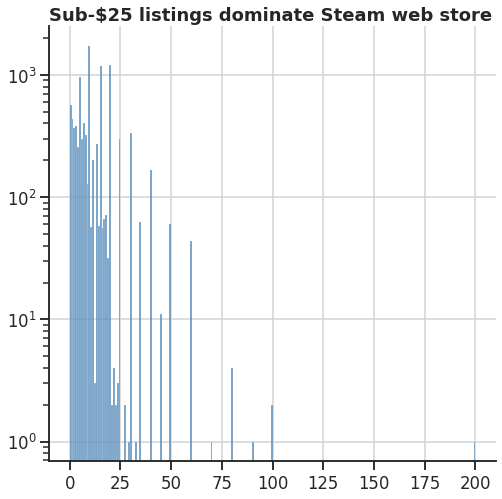

In [91]:
with sns.axes_style("ticks"):
    ax = sns.histplot(
        data=df[["original_price_cleaned"]],
        x="original_price_cleaned",
        log_scale=(False, True),
        color="steelblue",
    )
    ax.set_title(
        "Sub-$25 listings dominate Steam web store",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.grid(color="lightgrey")
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "13_num_listings_below_25_dollars.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

Histogram of listing discounts (as a percentage)

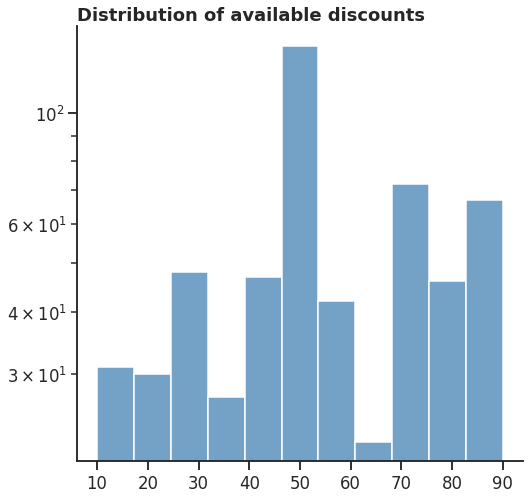

In [92]:
with sns.axes_style("ticks"):
    ax = sns.histplot(
        data=df[["discount_pct_cleaned"]],
        x="discount_pct_cleaned",
        log_scale=(False, True),
        color="steelblue",
    )
    ax.set_title(
        "Distribution of available discounts",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "14_distribution_of_discount_pct.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

Histogram of discounted listing price

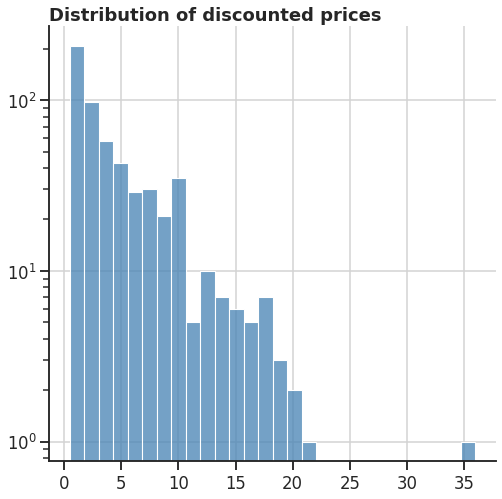

In [93]:
with sns.axes_style("ticks"):
    ax = sns.histplot(
        data=df[["discount_price"]],
        x="discount_price",
        log_scale=(False, True),
        color="steelblue",
    )
    ax.set_title("Distribution of discounted prices", loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.grid(color="lightgrey")
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "15_distribution_of_discount_price.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

<a id="listing-prices-over-time"></a>

### 4.14. [Listing Prices over time](#listing-prices-over-time)

**Show a heatmap of the median listing price by year and month since 2003. Do not include months of the year beyond the current month.**

Append columns to the cleaned data to get the year and month (by name)

In [94]:
df["release_year"] = df["release_date_cleaned"].dt.year
df["release_month"] = df["release_date_cleaned"].dt.month_name()

Get
- current year
- all months of the current year excluding future months

In [95]:
curr_year = datetime.now().year
curr_month = datetime.now().month - 1
months_upto_curr_month = months[:(curr_month)]
print(curr_year, months_upto_curr_month)

2021 ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']


Count the number of listings by year and month
- filter to only keep listings for the years from 2003 onwards upto the current year

In [96]:
df_dt_agg = (
    df.dropna(subset=["release_year", "release_month"])
    .astype({"release_year": int})
    .query("release_year >= 2003 " "and release_year <= @curr_year")
    .groupby(["release_year", "release_month"], as_index=False)[
        "original_price_cleaned"
    ]
    .median()
)
show_df(df_dt_agg, 5)

,release_year,release_month,original_price_cleaned
0,2003,April,9.990000
1,2003,August,6.990000
2,2003,December,6.490000
3,2003,February,7.990000
4,2003,January,9.990000
220,2021,March,12.990000
221,2021,May,11.990000
222,2021,November,52.490000
223,2021,October,7.990000
224,2021,September,9.990000


Set all future months of the current year to `None`

In [97]:
df_dt_agg.loc[
    df_dt_agg.query(
        "release_year == @curr_year and release_month not in @months_upto_curr_month"
    ).index,
    "original_price_cleaned",
] = np.nan

Pivot the aggregated data

In [98]:
year_month_price = df_dt_agg.pivot(
    index="release_month", columns="release_year", values="original_price_cleaned"
)
show_df(year_month_price)

release_year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
release_month,,,,,,,,,,,,,,,,,,,
April,9.990000,9.990000,4.990000,9.990000,5.490000,14.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,11.490000,13.490000,9.990000
August,6.990000,6.990000,9.990000,4.990000,4.990000,6.490000,9.990000,9.990000,9.990000,7.990000,9.990000,9.990000,9.990000,9.990000,11.990000,11.990000,11.990000,9.990000,9.990000
December,6.490000,nan,9.990000,9.990000,6.490000,9.990000,5.990000,7.990000,8.990000,8.990000,9.990000,9.990000,8.990000,9.490000,9.990000,9.990000,9.990000,10.990000,nan
February,7.990000,3.495000,6.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,11.990000,11.990000,9.990000
January,9.990000,9.990000,9.990000,11.490000,7.490000,nan,14.990000,5.990000,9.990000,8.490000,9.990000,9.990000,7.990000,9.990000,6.990000,7.990000,12.990000,11.990000,13.490000
July,nan,9.990000,9.990000,6.990000,9.990000,8.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,11.990000,13.490000,9.990000,9.990000
June,0.000000,8.990000,7.990000,8.990000,9.490000,9.990000,14.990000,9.990000,14.990000,9.990000,14.990000,9.990000,7.990000,9.990000,9.990000,8.490000,10.990000,9.990000,9.990000
March,6.640000,8.490000,9.990000,0.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,11.990000,12.990000
May,6.990000,9.990000,7.990000,9.990000,9.990000,9.990000,7.990000,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,8.490000,9.990000,9.990000,9.990000,9.990000,11.990000


Plot a heatmap of the orginal listing price by year and month, excluding year-month combinations from the future

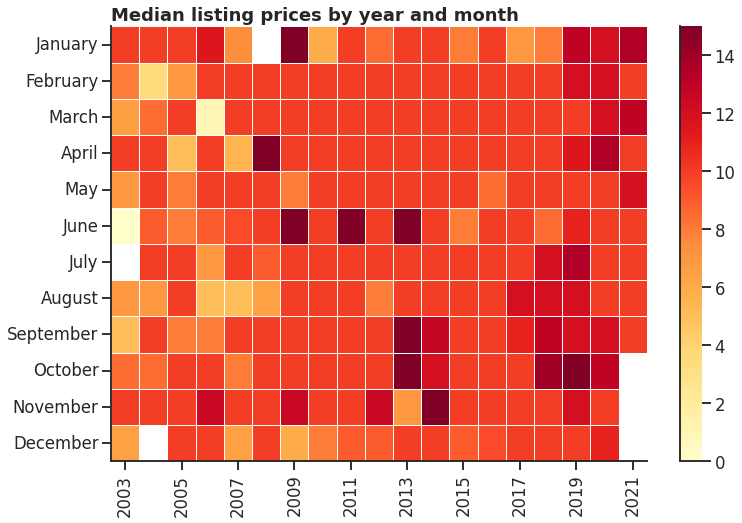

In [99]:
with sns.axes_style("ticks"):
    ax = sns.heatmap(
        data=year_month_price.loc[months],
        linewidths=0.5,
        cmap="YlOrRd",
    )
    ax.set_title(
        "Median listing prices by year and month", loc="left", fontweight="bold"
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(12)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "16_datetime_heatmap_price.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

**Plot the number of times each month the year has the most expensive median listing price.**

In [100]:
def get_max_index_in_group(
    df, index_col="release_month", colname="original_price_cleaned"
):
    return df.set_index(index_col)[colname].idxmax()

Do the following
- get the median listing price by year and month
- for each year, find the month with the highest median price

In [101]:
df_max_month_by_year = (
    df.query("release_year >= 2003 and release_year <= 2020")
    .dropna(subset=["release_year"])
    .astype({"release_year": int})
    .groupby(["release_year", "release_month"], as_index=False)[
        "original_price_cleaned"
    ]
    .median()
    .groupby("release_year", as_index=False)
    .apply(
        get_max_index_in_group,
        index_col="release_month",
        colname="original_price_cleaned",
    )
    .rename(columns={None: "max_month"})
)
show_df(df_max_month_by_year)

,release_year,max_month
0,2003,April
1,2004,April
2,2005,August
3,2006,November
4,2007,February
5,2008,April
6,2009,January
7,2010,April
8,2011,June
9,2012,November


Merge the above aggregated results with the full list of months of the year in order to get numbers for all 12 calendar months (fill months that do not appear on this list of most expensive median price months with zeros)

In [102]:
df_max_months = (
    df_max_month_by_year["max_month"]
    .value_counts()
    .reset_index()
    .merge(pd.Series(months, name="index").reset_index(), on="index", how="right")
    .drop(columns=["level_0"])
    .fillna(0)
    .astype({"max_month": int})
    .sort_values(by=["max_month"], ascending=False)
)
show_df(df_max_months)

,index,max_month
3,April,7
10,November,3
5,June,2
7,August,2
9,October,2
0,January,1
1,February,1
2,March,0
4,May,0
6,July,0


Plot the number of years for which each month has the the highest median price

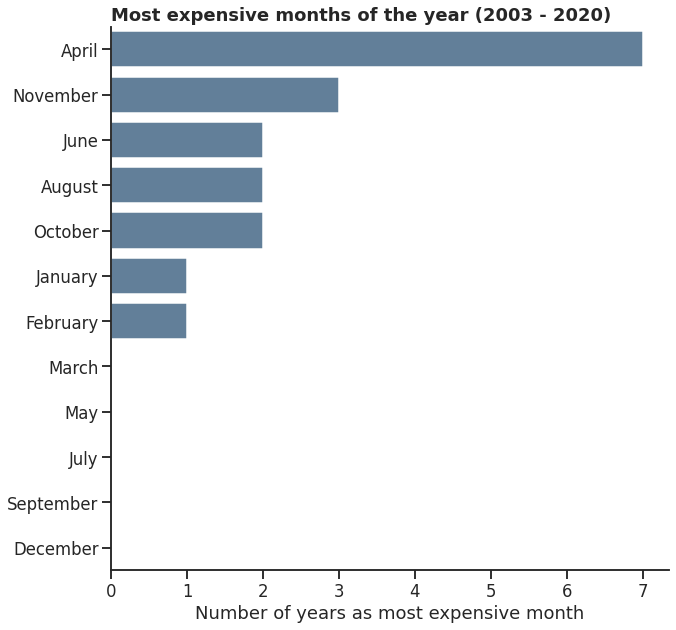

In [103]:
with sns.axes_style("ticks"):
    ax = sns.barplot(
        y="index",
        x="max_month",
        data=df_max_months,
        color="steelblue",
        saturation=0.5,
    )
    ax.set_title(
        "Most expensive months of the year (2003 - 2020)",
        loc="left",
        fontweight="bold",
    )
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Number of years as most expensive month")
    ax.set_ylabel(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    # fig.savefig(
    #     os.path.join(reports_data_dir, "17_prices_by_month.png"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

---

<span style="float:left">
    <a href="./6_merge_searches_listings.ipynb"><< 6 - Merge scraped Search Results Dataset with Listings Dataset</a>
</span>

<span style="float:right">
    <a href="./8_upload_cloud.ipynb">8 - Upload all scraped data (with requests and selenium) to cloud storage >></a>
</span>